# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [ ]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries. 필요한 라이브러리 추가로 호출

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [ ]:
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                         transforms.RandomCrop(32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                         #flipping 하고 싶으면 추가하기 #######################
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalize 바꾸고 싶으면 바꿔도 ok, but resize랑 totensor은 건들지 말기
                                         ])
#원래 세줄은 건들지 않는게 좋다.
#test set에 대한 transforms은 train set에 대한 transforms (flipping 위해 추가한 줄, normalize 숫자 바꾼 부분) 수정해서 그대로 transforms_cifar10_trainig이란 변수로 받을 것.

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
#optimization 할 때 minibatch 사이즈, default 값은 4로 설정, 여기서는 augmentation과 batch 사이즈만 바꾸면 됨. shuffling은 랜덤하게 가져오는 것. 순서 기억하지 않게. num_workers은 성능에 별로 영향을 주지 않는다. batch_size와 augmentation 정도만 바꾸면 된다.

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
#train이 아니라 test, augmentation 없고 resize하고 tensor로 만들어준 다음에 normalize한 형태.
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)
#testloader은 train dataset이랑 batch_size 동일하게, 기억하는 기능 필요 없기 때문에 shuffle 기능은 필요없다.

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck") #수정할 필요없다.

Files already downloaded and verified
Files already downloaded and verified


 bird plane  frog  ship


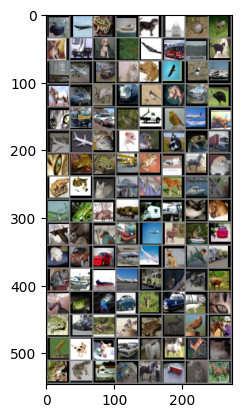

In [ ]:
# Examples of dataset 데이터가 잘 만들어졌음을 확인가능.

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [ ]:
# Model

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv_block = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),

            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels)
        )

        if self.stride != 1 or self.in_channels != self.out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.out_channels)
            )

    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            x = self.downsample(x)
        out = F.relu(x + out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = self.make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(512, num_blocks[3], stride=2)

        self.gap = nn.AvgPool2d(4)##############
        self.fc = nn.Linear(512, num_classes)################


    def make_layer(self, out_channels, num_block, stride):
        strides = [stride] + [1] * (num_block - 1)
        layers = []

        for stride in strides:
            block = ResidualBlock(self.in_channels, out_channels, stride)
            layers.append(block)
            self.in_channels = out_channels
        return nn.Sequential(*layers)


    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)

        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
num_blocks=[3,4,6,3]
model = ResNet(num_blocks).to(device)


# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

criterion = nn.CrossEntropyLoss()

GroundTruth:    cat  ship  ship plane
Predicted:  truck  bird truck  bird


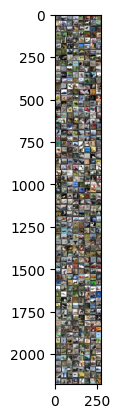

In [ ]:
# Test the trained model with sample 고치면 안된다.

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = model(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

# **Train the network**

Train your own network using the above loss function and optimizer.

Epoch 1/100 Train loss: 1.691 Train Acc: 37.03% Test loss: 1.786 Test Acc: 41.28%
Epoch 2/100 Train loss: 1.166 Train Acc: 57.82% Test loss: 1.316 Test Acc: 54.56%
Epoch 3/100 Train loss: 0.895 Train Acc: 68.08% Test loss: 1.063 Test Acc: 64.12%
Epoch 4/100 Train loss: 0.712 Train Acc: 75.13% Test loss: 0.714 Test Acc: 74.92%
Epoch 5/100 Train loss: 0.602 Train Acc: 79.13% Test loss: 0.662 Test Acc: 77.33%
Epoch 6/100 Train loss: 0.522 Train Acc: 82.03% Test loss: 0.540 Test Acc: 81.74%
Epoch 7/100 Train loss: 0.472 Train Acc: 83.72% Test loss: 0.557 Test Acc: 81.31%
Epoch 8/100 Train loss: 0.428 Train Acc: 85.30% Test loss: 0.482 Test Acc: 83.51%
Epoch 9/100 Train loss: 0.387 Train Acc: 86.67% Test loss: 0.505 Test Acc: 82.56%
Epoch 10/100 Train loss: 0.357 Train Acc: 87.79% Test loss: 0.445 Test Acc: 85.48%
Epoch 11/100 Train loss: 0.246 Train Acc: 91.54% Test loss: 0.319 Test Acc: 89.37%
Epoch 12/100 Train loss: 0.215 Train Acc: 92.60% Test loss: 0.315 Test Acc: 89.48%
Epoch 13/100 

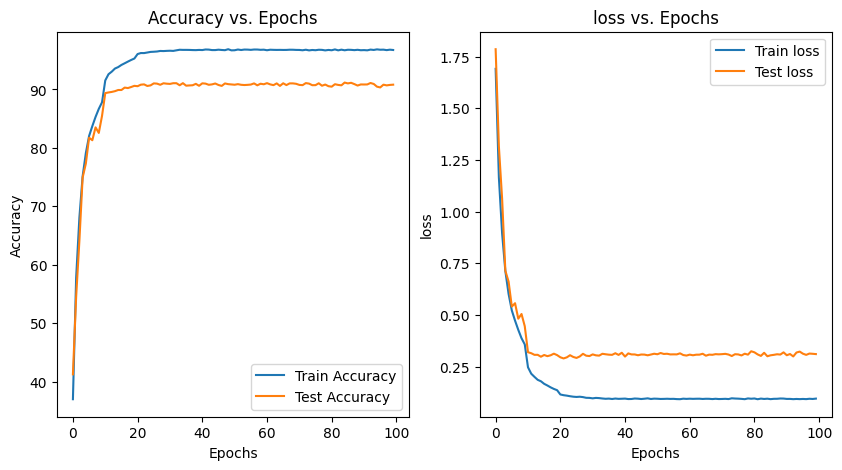

In [ ]:
import matplotlib.pyplot as plt
import random
# Assuming you have already defined trainloader and testloader
random.seed(42)
epochs = 100  # number of epochs
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
    # Training phase
    model.train()  # Set the network to training mode
    total_train = 0
    correct_train = 0
    loss_tmp = 0.0
    epoch_loss_train = 0.0
    for i, data in enumerate(trainloader, start=0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss_train += loss.data
        loss_tmp += loss.data

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if i % 5000 == 4999:
            loss_tmp = 0.0

    train_loss.append(epoch_loss_train / len(trainloader))
    train_accuracy.append(100 * correct_train / total_train)

    # Testing phase
    model.eval()  # Set the network to evaluation mode
    total_test = 0
    correct_test = 0
    epoch_loss_test = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_loss_test += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss.append(epoch_loss_test / len(testloader))
    test_accuracy.append(100 * correct_test / total_test)

    # Update learning rate
    scheduler.step()

    # Print stats
    print(f'Epoch {epoch+1}/{epochs} Train loss: {train_loss[-1]:.3f} Train Acc: {train_accuracy[-1]:.2f}% Test loss: {test_loss[-1]:.3f} Test Acc: {test_accuracy[-1]:.2f}%')

# 가정: train_loss는 GPU Tensor의 리스트
train_loss_cpu = [loss.cpu() for loss in train_loss]  # 각 요소를 CPU로 이동
train_loss_numpy = [loss.numpy() for loss in train_loss_cpu]  # 각 요소를 NumPy 배열로 변환
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accuracy, label='Train Accuracy')
plt.plot(range(epochs), test_accuracy, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_numpy, label='Train loss')
plt.plot(range(epochs), test_loss, label='Test loss')
plt.title('loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()


## **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


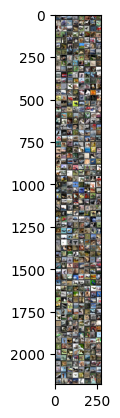

In [ ]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = model(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
# Test the trained model with overall test dataset

model.eval()
correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = model(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 12 %

Accuracy of the network on the 10,000 test images: 90 %
